In [20]:
# ==============================================================================
#  라이브러리 임포트
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # 로컬에서는 tqdm.notebook 대신 일반 tqdm 사용
from tqdm.contrib.concurrent import thread_map
import joblib
import random

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import pairwise_distances, silhouette_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample


# joblib (병렬 처리를 위해)
from joblib import Parallel, delayed

# faiss (KNN 가속화를 위해)
import faiss

# 데이터 관련 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt

# Ensemble
from Ensemble import EnsembleFaissKNN

#DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/Google_Recaptcha_V2_Images_Dataset"

print("✔ 모든 라이브러리 임포트 완료!")

✔ 모든 라이브러리 임포트 완료!


In [21]:
# ==============================================================================
#  데이터 로드 함수
# ==============================================================================

# 이미지 로드 함수
def load_images_from_folder(base_path):
    images = []
    labels = []
    image_folder_path = os.path.join(base_path, 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"이미지 폴더를 찾을 수 없습니다: {image_folder_path}\n"
                                f"DATASET_BASE_PATH를 올바르게 설정했는지 확인해주세요.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="폴더 로드 중"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"경고: {img_path} 이미지를 로드할 수 없습니다.")
                except Exception as e:
                    print(f"경고: {img_path} 로딩 중 오류 발생 - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

def visualize_features(X_feats, y_labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)

    X_reduced = reducer.fit_transform(X_feats)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f'Feature Distribution via {method.upper()}')
    plt.colorbar(scatter, ticks=range(len(set(y_labels))))
    plt.tight_layout()
    plt.show()

In [22]:
def edge(img_bgr):
    # 1) 강제 리사이즈
    img_bgr = cv2.resize(img_bgr, (120, 120), interpolation=cv2.INTER_AREA)

    # 2) CLAHE → Gray → Blur → Denoise → Canny
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8,8))
    l = clahe.apply(l)
    img_eq = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

    gray = cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    denoised = cv2.fastNlMeansDenoising(blurred, h=10, templateWindowSize=7, searchWindowSize=21)
    edges = cv2.Canny(denoised, 100, 230)

    #plt.imshow(edges, cmap='gray')
    #plt.title("Preprocessed")
    #plt.axis('off')
    #plt.show()
    return edges  # 항상 (IMG_SIZE, IMG_SIZE)

# 1) 공통: BGR → LAB → CLAHE(L) → BGR (필요 시)
def apply_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.createCLAHE(2.0, (8,8)).apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2BGR)

# 3) Unsharp mask (SIFT 전용)
def unsharp(img_gray):
    blurred = cv2.GaussianBlur(img_gray, (3,3), 0)
    return cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# 4) Mild Gaussian blur (LBP/GLCM/Laws)
def mild_blur(img_gray):
    return cv2.GaussianBlur(img_gray, (3,3), 0)

In [23]:
def gray(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

In [24]:
def checkcol(img_bgr):
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    #image=cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #image = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8,8,8), [0,180, 0,256, 0,256])
    hist = cv2.normalize(hist, hist).flatten()
    h, s, v = cv2.split(hsv)
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hist_rgb = cv2.calcHist([rgb], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_rgb = cv2.normalize(hist_rgb, hist_rgb).flatten()
    hist_bgr = cv2.calcHist([img_bgr], [0, 1, 2], None, (8,8,8), [0,256, 0,256, 0,256])
    hist_bgr = cv2.normalize(hist_bgr, hist_bgr).flatten()
    #plt.imshow(v)
    #plt.title("Color")
    #plt.axis('off')
    #plt.show()
     # ✅ 2D 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(hist, color='blue')
    plt.title("Flattened HSV Histogram")
    plt.xlabel("Bin Index")
    plt.ylabel("Normalized Value")
    plt.tight_layout()
    plt.show()
    return hsv


In [25]:
tst = "C:/Users/bvb09/.cache/kagglehub/datasets/pre"
timg = load_images_from_folder(tst)
timg['processed_image_data'] = [edge(img) for img in tqdm(timg['image_data'], desc="이미지 전처리")]

이미지 전처리: 100%|██████████| 8/8 [00:00<00:00, 39.99it/s]


In [26]:
# ==============================================================================
#  피쳐 추출 함수
# ==================================================================:============

def extract_color_histogram_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, (8,8,8), [0,180,0,256,0,256])
    return cv2.normalize(hist, hist).flatten()

def extract_sift_pca_mean(img_bgr, pca_model=None, n_components=32):
    # 1. BGR → GRAY
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # 2. SIFT 생성 및 디스크립터 추출
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)

    if descriptors is None or len(descriptors) == 0:
        # 디스크립터 없을 경우 0 벡터 반환
        return np.zeros(n_components if pca_model else 128, dtype=np.float32)

    # 3. PCA 처리
    if pca_model is None:
        # PCA 학습도 포함 (보통 학습셋에서 따로 학습하는 게 좋음)
        pca_model = PCA(n_components=n_components)
        descriptors_pca = pca_model.fit_transform(descriptors)
    else:
        descriptors_pca = pca_model.transform(descriptors)

    # 4. 평균 벡터 반환
    mean_vector = np.mean(descriptors_pca, axis=0)
    return mean_vector.astype(np.float32)

def extract_glcm_features(image):
    if image is None:
        num_props = 6
        num_distances = 3 # 아래 distances 리스트 길이
        num_angles = 4    # 아래 angles 리스트 길이
        return np.zeros(num_props * num_distances * num_angles)
    
    img_glcm = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_glcm = mild_blur(img_glcm)
    img_glcm = apply_clahe(cv2.cvtColor(img_glcm, cv2.COLOR_GRAY2BGR))
    gray_image = cv2.cvtColor(img_glcm, cv2.COLOR_BGR2GRAY)

    distances = [1, 2, 3] # 예시 거리 값
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 예시 각도 값
    
    try:
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
        
        props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        glcm_features = []
        for prop in props_to_extract:
            glcm_features.append(graycoprops(glcm, prop).ravel())
            
        return np.concatenate(glcm_features)
    except Exception as e:
        # 오류 발생 시 처리 (예: 0으로 채워진 배열 반환)
        print(f"GLCM 추출 중 오류 발생: {e}")
        num_props = 6
        num_distances = len(distances) 
        num_angles = len(angles)    
        return np.zeros(num_props * num_distances * num_angles)

def extract_hog_features(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
     # 1) 리사이즈
    img = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA)
    # 2) 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    features = hog(gray,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True,
                   feature_vector=True)
    return features.astype(np.float32)

def extract_sift_descriptors_from_array(image):
    img = apply_clahe(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image=unsharp(img)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_image, None) # 키포인트와 디스크립터 계산

    return des # 디스크립터가 없을 경우 None 반환

def extract_lbp_features_from_array(image, P=8, R=1, method='uniform'):
    
    image=apply_clahe(image)
    #image=mild_blur(image)
    gray_image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # local_binary_pattern 함수는 float 타입 이미지를 선호하지만, skimage는 UBYTE도 처리
    lbp_image = local_binary_pattern(gray_image, P, R, method=method)

    # LBP 히스토그램 계산
    max_bins = P * (P - 1) + 3 if method == 'default' else P + 2 # uniform의 경우 P+2
    hist, _ = np.histogram(lbp_image.ravel(), bins=max_bins, range=(0, max_bins), density=True)
    return hist

# Laws' Texture Energy - 기존과 동일
def extract_laws_energy_features(image, window_size=15):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray=mild_blur(image_gray)

    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

def learn_bovw_vocabulary(all_sift_descriptors, num_clusters=200):
    """
    Bag of Visual Words (BoVW)를 위한 시각적 단어(Vocabulary)를 학습합니다.
    """
    filtered = [des for des in all_sift_descriptors if des is not None and len(des) > 0]

    # ✔ 차원 확인: 모든 디스크립터의 feature 차원이 같아야 함
    feature_dims = {des.shape[1] for des in filtered}
    if len(feature_dims) > 1:
        raise ValueError(f"❌ BoVW 학습용 SIFT 디스크립터들의 차원이 일치하지 않음: {feature_dims}")

    concatenated_descriptors = np.vstack(filtered)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, _, centers = cv2.kmeans(
        concatenated_descriptors.astype(np.float32),
        num_clusters, None, criteria, 10, flags
    )
    return centers


def create_bovw_histogram(sift_descriptors, vocabulary):
    """
    단일 이미지의 SIFT → BoVW 히스토그램 (벡터화 버전)
    """
    num_clusters = vocabulary.shape[0]
    if sift_descriptors is None or len(sift_descriptors) == 0:
        return np.zeros(num_clusters, dtype=np.float32)

    try:
        # ✔ 유클리디언 거리 계산 (벡터화)
        distances = np.linalg.norm(
            vocabulary[None, :, :] - sift_descriptors[:, None, :], axis=2
        )  # shape: (num_des, num_clusters)

        closest_clusters = np.argmin(distances, axis=1)
        histogram = np.bincount(closest_clusters, minlength=num_clusters).astype(np.float32)
        histogram = cv2.normalize(histogram, None, norm_type=cv2.NORM_L2).flatten()
        return histogram

    except Exception as e:
        print(f"⚠️ BoVW 히스토그램 생성 오류: {e}")
        return np.zeros(num_clusters, dtype=np.float32)


def parallel_create_bovw_histograms(descriptor_list, vocabulary, n_jobs=6):
    """
    여러 이미지의 SIFT → BoVW 히스토그램 (멀티프로세싱)
    """
    histograms = Parallel(n_jobs=n_jobs)(
        delayed(create_bovw_histogram)(desc, vocabulary) for desc in descriptor_list
    )
    return np.array(histograms, dtype=np.float32)

print("✔ 특징 추출 함수 정의 완료")

✔ 특징 추출 함수 정의 완료


In [27]:
def get_features_for_split(df, image_dir, bovw_vocabulary=None, num_bovw_clusters=200):

    hog_feats = []
    color_feats = []
    lbp_feats = []
    sift_descriptors_raw = [] # SIFT 디스크립터만

    dataset_name = df.name if hasattr(df, 'name') else 'dataset'
    print(f"Loading images and extracting raw features for {dataset_name}...")

    # 이미지를 한 번 로드하고, 이를 각 특징 추출 함수에 전달
    for img_name in tqdm(df['image_name'], desc=f"Processing images for {dataset_name}"):
        img_path = os.path.join(image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")

        # 모든 이미지가 이미 120x120으로 리사이즈되었다고 가정하므로, 추가 리사이즈 없음
        # 다만, cv2.imread는 BGR로 읽으므로, 컬러 히스토그램을 위해 RGB 변환은 필요
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB 변환은 여기서 한 번만 수행

        # 각 특징 추출 함수에 이미지 배열 전달
        hog_feats.append(extract_hog_features(image_rgb)) # HOG는 내부에서 GRAY 변환
        color_feats.append(extract_color_histogram_features(image_rgb))
        lbp_feats.append(extract_lbp_features_from_array(image_rgb)) # LBP는 내부에서 GRAY 변환
        sift_descriptors_raw.append(extract_sift_descriptors_from_array(image_rgb)) # SIFT는 내부에서 GRAY 변환


    current_bovw_vocab = bovw_vocabulary
    if current_bovw_vocab is None: # 학습 데이터에서만 Vocabulary 학습
        print(f"Learning BoVW vocabulary for {dataset_name}...")
        current_bovw_vocab = learn_bovw_vocabulary(sift_descriptors_raw, num_clusters=num_bovw_clusters)
        print(f"BoVW vocabulary learned with {current_bovw_vocab.shape[0]} clusters.")

    all_bovw_feats = []
    print(f"Creating BoVW histograms for {dataset_name}...")
    for sift_des in tqdm(sift_descriptors_raw):
        all_bovw_feats.append(create_bovw_histogram(sift_des, current_bovw_vocab))

    return (np.array(hog_feats), np.array(color_feats),
            np.array(all_bovw_feats), np.array(lbp_feats), current_bovw_vocab)


def combine_features(*feature_arrays):
    reshaped = []
    for arr in feature_arrays:
        arr = np.asarray(arr)
        if arr.ndim == 3:
            # (N, H, W) → (N, H*W)
            arr = arr.reshape(arr.shape[0], -1)
        elif arr.ndim == 1:
            # (D,) → (1, D)
            arr = arr.reshape(1, -1)
        reshaped.append(arr)
    return np.hstack(reshaped)


In [28]:
# ==============================================================================
#  분류 모델 및 학습/평가 함수
# ==============================================================================
# 유클리드 거리 기반 Faiss KNN 학습 (수정됨)
def train_faiss_knn_euclidean(X_train, y_train, n_neighbors=3):
    # 유클리드 거리 기반에서는 데이터 정규화가 필요 없습니다.
    # X_train = normalize(X_train, axis=1) # 이 줄을 주석 처리하거나 삭제합니다.
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]

    # Inner Product (IP) 대신 L2 거리를 사용하는 인덱스를 생성합니다.
    index = faiss.IndexFlatL2(D) # <-- 변경된 부분
    index.add(X_train)

    return index, y_train, n_neighbors

# 유클리드 거리 기반 Faiss KNN 예측 (수정됨)
def predict_faiss_knn_euclidean(index, y_train_labels, n_neighbors, X_test):
    # 유클리드 거리 기반에서는 테스트 데이터 정규화도 필요 없습니다.
    # X_test = normalize(X_test, axis=1) # 이 줄을 주석 처리하거나 삭제합니다.
    X_test = X_test.astype(np.float32)

    # search 결과는 D (거리)와 I (인덱스)입니다.
    # L2 거리이므로 거리가 작을수록 가까운 것입니다.
    distances, indices = index.search(X_test, n_neighbors) # <-- 이름 변경 (similarities -> distances)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        # 거리 기반이므로 가장 가까운 이웃들의 레이블을 통해 다수결 투표
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

def predict_faiss_knn_euclidean_topk(index, y_train_labels, n_neighbors, X_test):
    """
    Faiss Top-K 예측 레이블 리스트 반환 (예: k=10일 때 각 샘플마다 10개 레이블 리스트)
    """
    X_test = X_test.astype(np.float32)
    distances, indices = index.search(X_test, n_neighbors)

    topk_labels = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        topk_labels.append(neighbor_labels.tolist())
    return topk_labels

def task2_score(y_true, topk_preds, topk=10):
    """
    각 샘플마다 Top-10 예측 중 정답이 몇 번 포함되었는지 → 평균 비율 반환
    """
    match_counts = [
        pred_list.count(true_label) / topk
        for true_label, pred_list in zip(y_true, topk_preds)
    ]
    return np.mean(match_counts)

# test() 함수
def test(model_tuple, X_test, y_test, average='weighted', topk=10):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors})...")
    
    # Top-1 예측 (기존)
    y_pred = predict_faiss_knn_euclidean(faiss_index, y_train_labels, n_neighbors, X_test)

    # Top-k 예측
    topk_labels = predict_faiss_knn_euclidean_topk(faiss_index, y_train_labels, topk, X_test)

    # Top-10 Accuracy 계산
    topk_hits = [true in pred_list for true, pred_list in zip(y_test, topk_labels)]
    topk_acc = np.mean(topk_hits)

    print("  ✔ 예측 완료.")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)

    print(f"[Top-1 Accuracy]  {acc:.4f}")
    print(f"[Top-{topk} Accuracy] {topk_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"[Task2 Accuracy (Top-10 Same-Class)] {task2_acc:.4f}")
    
    return y_pred

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


In [29]:
def augment_image(img):
    """이미지 하나에 대해 여러 증강 중 하나를 랜덤 적용"""
    choice = random.choice(['flip', 'rotate', 'brightness', 'blur', 'noise'])

    if choice == 'flip':
        return cv2.flip(img, 1)  # 좌우반전
    elif choice == 'rotate':
        angle = random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif choice == 'brightness':
        factor = random.uniform(0.7, 1.3)
        return np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    elif choice == 'blur':
        return cv2.GaussianBlur(img, (5, 5), 0)
    elif choice == 'noise':
        noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
        return cv2.add(img, noise)
    return img  # fallback

def augment_to_balance_min(df, target_min_per_class=500, seed=42):
    """클래스별로 최소 target 개수를 확보하도록 증강 (많은 클래스는 그대로 유지)"""
    random.seed(seed)
    np.random.seed(seed)

    augmented_rows = []

    for label, group in df.groupby('label'):
        n_current = len(group)
        n_needed = target_min_per_class - n_current

        if n_needed <= 0:
            print(f"✅ {label}: {n_current}개 → 그대로 유지 (증강 없음)")
            augmented_rows.append(group)  # 그대로 사용 (잘라내지 않음!)
        else:
            print(f"➕ {label}: {n_current}개 → {target_min_per_class}개로 증강 중 ({n_needed}개 생성)")
            samples_to_augment = group.sample(n=n_needed, replace=True, random_state=seed)

            new_rows = []
            for _, row in samples_to_augment.iterrows():
                new_img = augment_image(row['image_data'])
                new_rows.append({
                    'label': row['label'],
                    'image_data': new_img
                })
            augmented_rows.append(group)
            augmented_rows.append(pd.DataFrame(new_rows))

    balanced_df = pd.concat(augmented_rows).reset_index(drop=True)
    return balanced_df



In [30]:
DATASET_BASE_PATH = "C:/Users/bvb09/recaptcha-dataset" 

try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    

# 2. 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스: {le.classes_}")

images_df = images_df.groupby('label').apply(
    lambda g: g.sample(n=1500, random_state=42) if g.name in ['Car', 'Bus'] else g
).reset_index(drop=True)

images_df = augment_to_balance_min(images_df)
images_df['label_encoded'] = le.fit_transform(images_df['label'])

# 전체 이미지 데이터에 대해 전처리 수행
#print("⏳ 전체 이미지 전처리 중...")
#images_df['processed_image_data'] = [preprocess_image(img) for img in tqdm(images_df['image_data'], desc="이미지 전처리")]
#print("✔ 전체 이미지 전처리 완료.")


폴더 로드 중: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]

✔ 총 12700개의 이미지 로드 완료.
✔ 라벨 인코딩 완료. 클래스: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Palm' 'Traffic Light']
✅ Bicycle: 1299개 → 그대로 유지 (증강 없음)
✅ Bridge: 553개 → 그대로 유지 (증강 없음)
✅ Bus: 1500개 → 그대로 유지 (증강 없음)
✅ Car: 1500개 → 그대로 유지 (증강 없음)
➕ Chimney: 431개 → 500개로 증강 중 (69개 생성)
✅ Crosswalk: 1260개 → 그대로 유지 (증강 없음)
✅ Hydrant: 1032개 → 그대로 유지 (증강 없음)
✅ Motorcycle: 681개 → 그대로 유지 (증강 없음)
✅ Palm: 932개 → 그대로 유지 (증강 없음)
✅ Traffic Light: 905개 → 그대로 유지 (증강 없음)



C:\Users\bvb09\AppData\Local\Temp\ipykernel_8440\2476747336.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images_df = images_df.groupby('label').apply(


In [31]:
# 전체 이미지 데이터에 대해 기본 특징 미리 추출
print("⏳ 기본 특징 추출 중 (Color, HOG, LBP, SIFT descriptors)...")
features_color_all = np.array([extract_color_histogram_features(img) for img in tqdm(images_df['image_data'], desc="Color Histogram 추출")])

⏳ 기본 특징 추출 중 (Color, HOG, LBP, SIFT descriptors)...


Color Histogram 추출: 100%|██████████| 10162/10162 [00:00<00:00, 17754.17it/s]


In [32]:
features_lbp_all = np.array([extract_lbp_features_from_array(img) for img in tqdm(images_df['image_data'], desc="LBP 추출")])


LBP 추출: 100%|██████████| 10162/10162 [00:19<00:00, 527.11it/s]


In [33]:
hog_list = [
    extract_hog_features(img)
    for img in tqdm(images_df['image_data'], desc="HOG 추출")
]
features_hog_all = np.vstack(hog_list)  # shape = (n_images, hog_dim)
print(features_hog_all.shape)
pca = PCA(n_components=50, random_state=42)
features_hog_all = pca.fit_transform(features_hog_all)


HOG 추출: 100%|██████████| 10162/10162 [00:15<00:00, 651.58it/s]


(10162, 1296)


In [34]:
#features_glcm_all = np.array([extract_glcm_features(img) for img in tqdm(images_df['image_data'], desc="GLCM 추출")])

In [35]:
features_laws_all = np.array([extract_laws_energy_features(img) for img in tqdm(images_df['image_data'], desc="Laws' Texture 추출")])

Laws' Texture 추출: 100%|██████████| 10162/10162 [01:07<00:00, 151.12it/s]


In [36]:
def pca_reduce_descriptors(sift_descriptors_list_all, n_components=64):
    """
    모든 이미지의 SIFT 디스크립터에 대해 PCA를 적용해 차원 축소.
    PCA는 전체 디스크립터에서 1회 학습한 뒤, 각 디스크립터에 transform만 적용.
    """
    # 유효한 디스크립터만 추출 (None 제거, 최소 차원 이상)
    valid_descriptors = [d for d in sift_descriptors_list_all if d is not None and len(d) >= n_components]
    
    if len(valid_descriptors) == 0:
        print("❌ PCA 학습할 디스크립터가 충분하지 않음. 차원 축소를 생략합니다.")
        return sift_descriptors_list_all

    # 전체 디스크립터 결합
    all_descriptors = np.vstack(valid_descriptors)

    # PCA 학습
    print(f"🔍 PCA 학습 중... (입력 차원: {all_descriptors.shape[1]} → {n_components})")
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(all_descriptors)

    # 병렬 변환 함수
    def transform_if_valid(desc):
        if desc is None or len(desc) < n_components:
            return desc
        return pca.transform(desc)

    # 병렬 적용
    print("⚙ PCA 변환 병렬 적용 중...")
    reduced_descriptors = Parallel(n_jobs=6)(
        delayed(transform_if_valid)(desc) for desc in sift_descriptors_list_all
    )
    
    print("✅ PCA 축소 완료")
    return reduced_descriptors

In [37]:
sift_descriptors_list_all = [extract_sift_descriptors_from_array(img) for img in tqdm(images_df['image_data'], desc="SIFT Descriptors 추출")]

# 전체 이미지 수
total_count = len(sift_descriptors_list_all)

# PCA 학습에 사용할 디스크립터만 필터링 (128차원인 경우만)
all_descriptors = [des for des in sift_descriptors_list_all if des is not None and des.shape[1] == 128]
pca_image_count = len(all_descriptors)  # 디스크립터가 존재하고 128차원인 이미지 수

X_all = np.vstack(all_descriptors)

# PCA 학습
pca = PCA(n_components=64, random_state=42)
pca.fit(X_all)

print(f"📊 전체 이미지 수: {total_count}")
print(f"📊 PCA 학습에 사용된 디스크립터가 있는 이미지 수: {pca_image_count}")
print(f"📊 PCA 학습에 사용된 전체 SIFT 벡터 수: {X_all.shape[0]}")

# PCA 변환 적용
sift_descriptors_list_all = [
    pca.transform(des) if des is not None and des.shape[1] == 128 else None
    for des in sift_descriptors_list_all
]


SIFT Descriptors 추출: 100%|██████████| 10162/10162 [02:21<00:00, 72.02it/s]


📊 전체 이미지 수: 10162
📊 PCA 학습에 사용된 디스크립터가 있는 이미지 수: 10162
📊 PCA 학습에 사용된 전체 SIFT 벡터 수: 1756451



▶ 총 4개의 특징 조합에 대해 교차 검증을 수행합니다.
  - ('color', 'lbp')
  - ('color', 'lbp', 'hog')
  - ('color', 'law', 'hog')
  - ('color', 'lbp', 'sift', 'hog')

✔ Stratified K-Fold 설정 완료 (5-Fold)

=============== FOLD 1/5 ================
  ⏳ BoVW Vocabulary 학습 중 (Fold 1)

--- 조합: color+lbp (Fold 1) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 1, 조합 color+lbp)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 1, 조합 color+lbp)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.3586
    ├ Top-10 Accuracy: 0.8421 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3119 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.3607 (Fold 1, 조합 color+lbp)


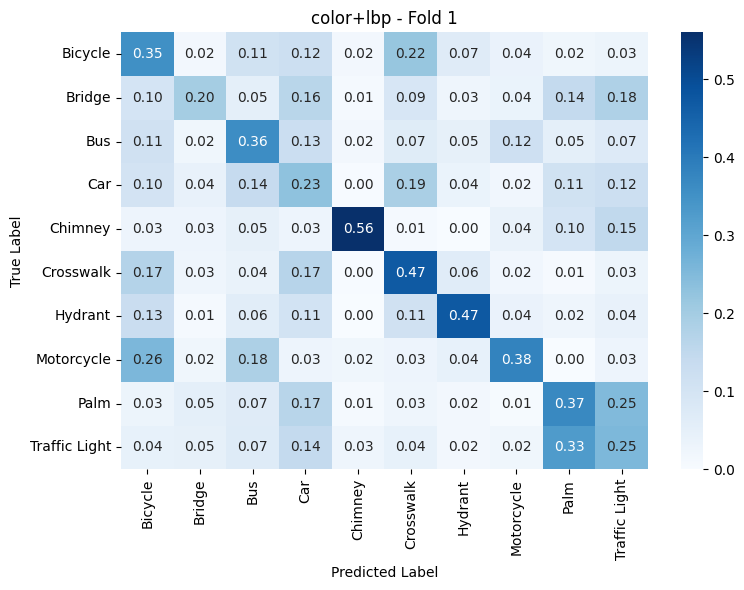


--- 조합: color+lbp+hog (Fold 1) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 1, 조합 color+lbp+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 1, 조합 color+lbp+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4806
    ├ Top-10 Accuracy: 0.8746 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3861 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4755 (Fold 1, 조합 color+lbp+hog)


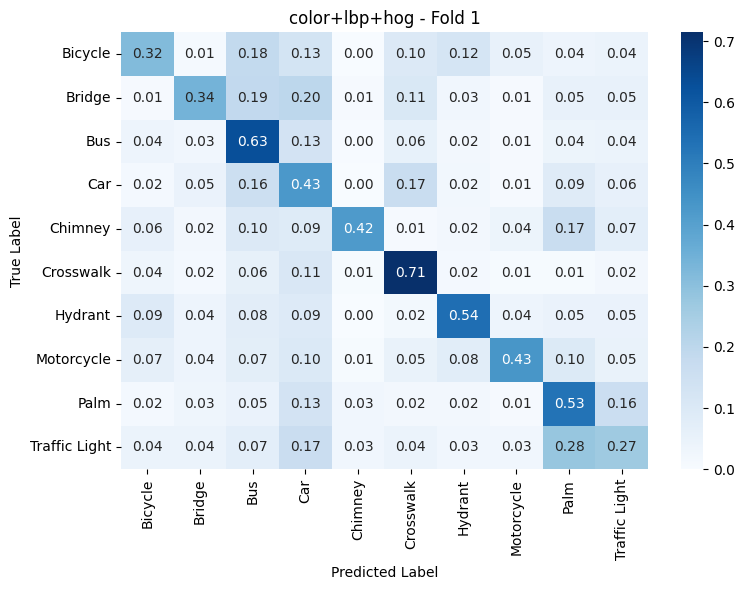


--- 조합: color+law+hog (Fold 1) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 1, 조합 color+law+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 1, 조합 color+law+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4791
    ├ Top-10 Accuracy: 0.8726 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3852 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4733 (Fold 1, 조합 color+law+hog)


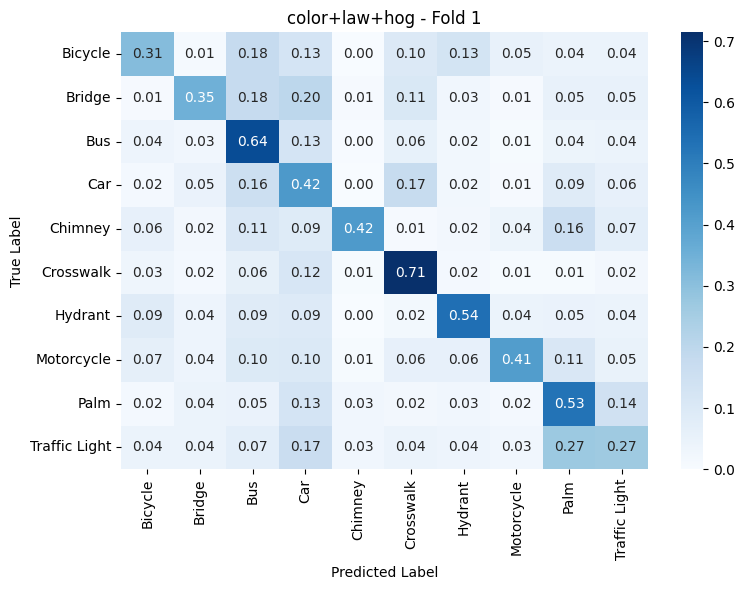


--- 조합: color+lbp+sift+hog (Fold 1) ---
  ✔ BoVW Vocabulary 학습 완료 (200 clusters).
  ⏳ BoVW Histogram 생성 중 (Fold 1, 조합 color+lbp+sift+hog)...
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 1, 조합 color+lbp+sift+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 1, 조합 color+lbp+sift+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4934
    ├ Top-10 Accuracy: 0.8908 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.4007 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4899 (Fold 1, 조합 color+lbp+sift+hog)


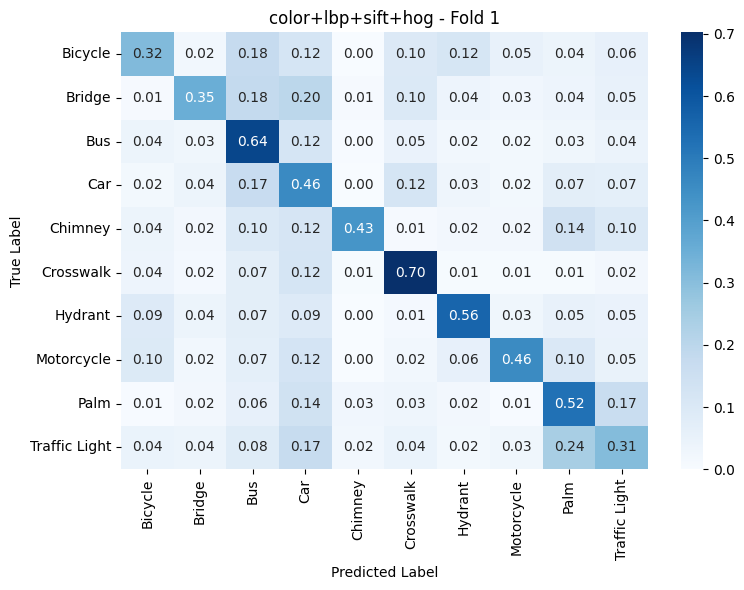


=============== FOLD 2/5 ================
  ⏳ BoVW Vocabulary 학습 중 (Fold 2)

--- 조합: color+lbp (Fold 2) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 2, 조합 color+lbp)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 2, 조합 color+lbp)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.3620
    ├ Top-10 Accuracy: 0.8485 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3166 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.3624 (Fold 2, 조합 color+lbp)


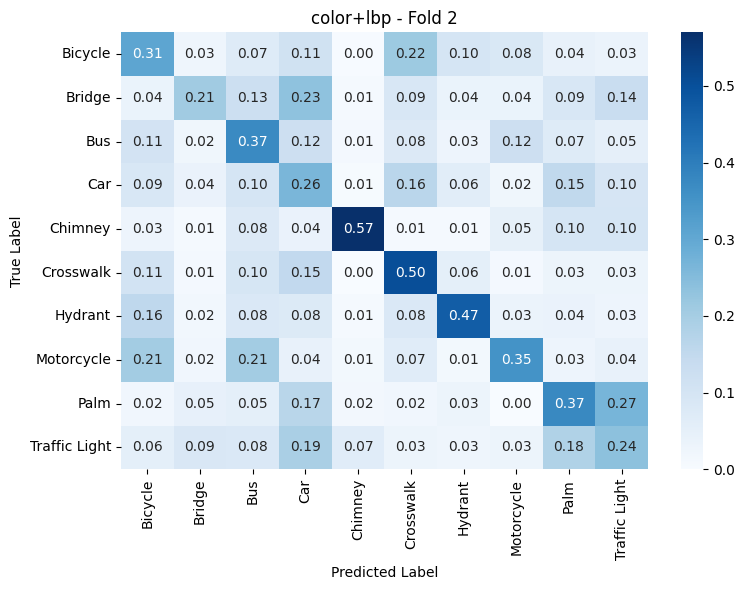


--- 조합: color+lbp+hog (Fold 2) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 2, 조합 color+lbp+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 2, 조합 color+lbp+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4727
    ├ Top-10 Accuracy: 0.8711 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3798 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4712 (Fold 2, 조합 color+lbp+hog)


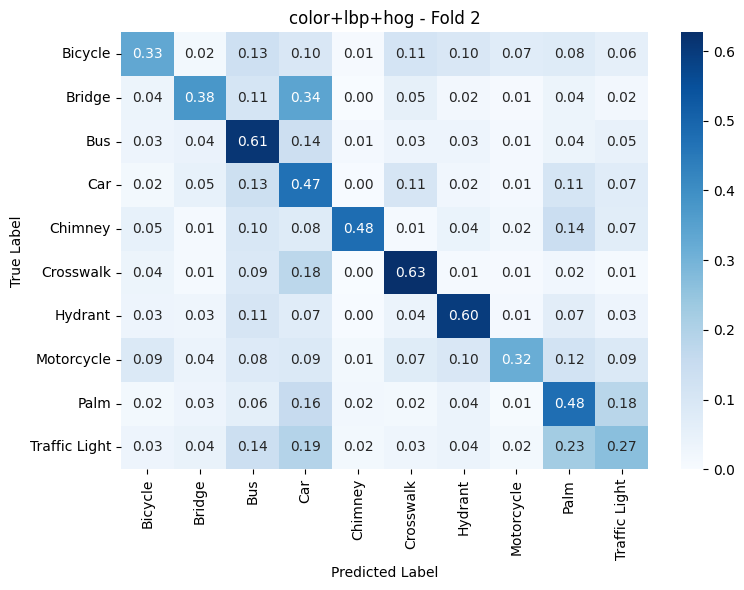


--- 조합: color+law+hog (Fold 2) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 2, 조합 color+law+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 2, 조합 color+law+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4727
    ├ Top-10 Accuracy: 0.8721 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3786 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4710 (Fold 2, 조합 color+law+hog)


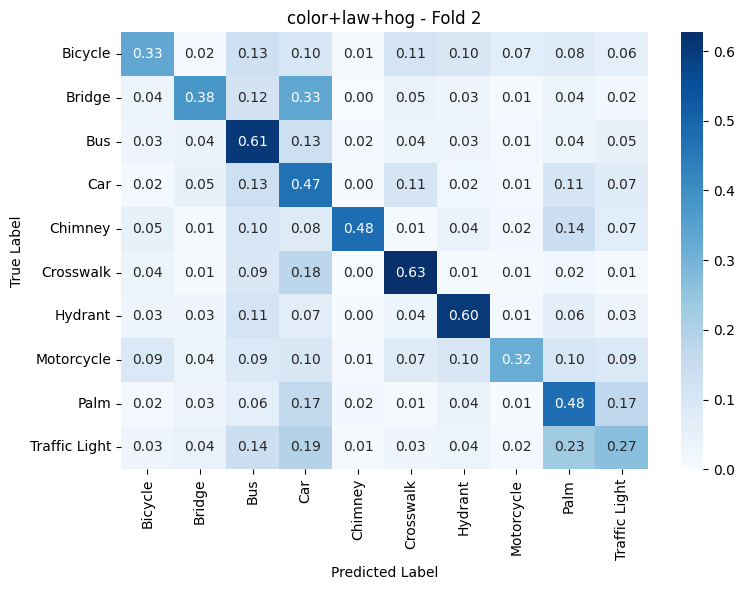


--- 조합: color+lbp+sift+hog (Fold 2) ---
  ✔ BoVW Vocabulary 학습 완료 (200 clusters).
  ⏳ BoVW Histogram 생성 중 (Fold 2, 조합 color+lbp+sift+hog)...
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 2, 조합 color+lbp+sift+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 2, 조합 color+lbp+sift+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4860
    ├ Top-10 Accuracy: 0.8879 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3941 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4879 (Fold 2, 조합 color+lbp+sift+hog)


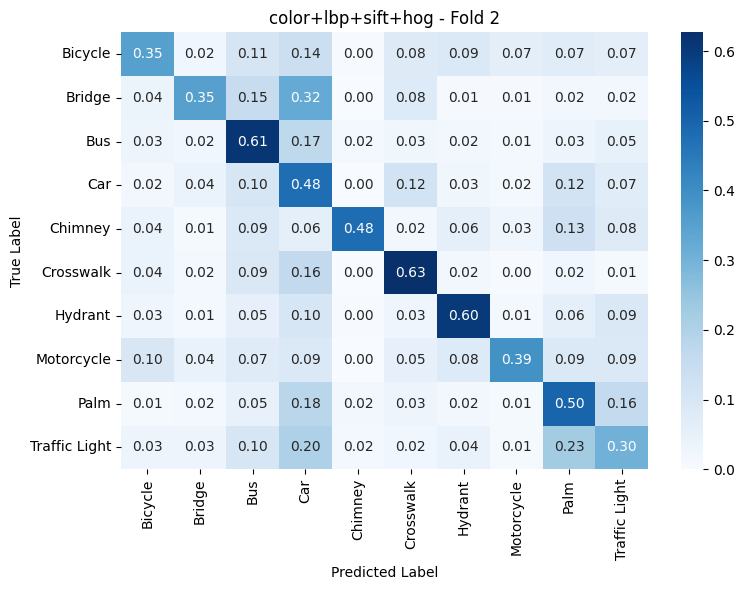


=============== FOLD 3/5 ================
  ⏳ BoVW Vocabulary 학습 중 (Fold 3)

--- 조합: color+lbp (Fold 3) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 3, 조합 color+lbp)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 3, 조합 color+lbp)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.3642
    ├ Top-10 Accuracy: 0.8602 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3172 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.3640 (Fold 3, 조합 color+lbp)


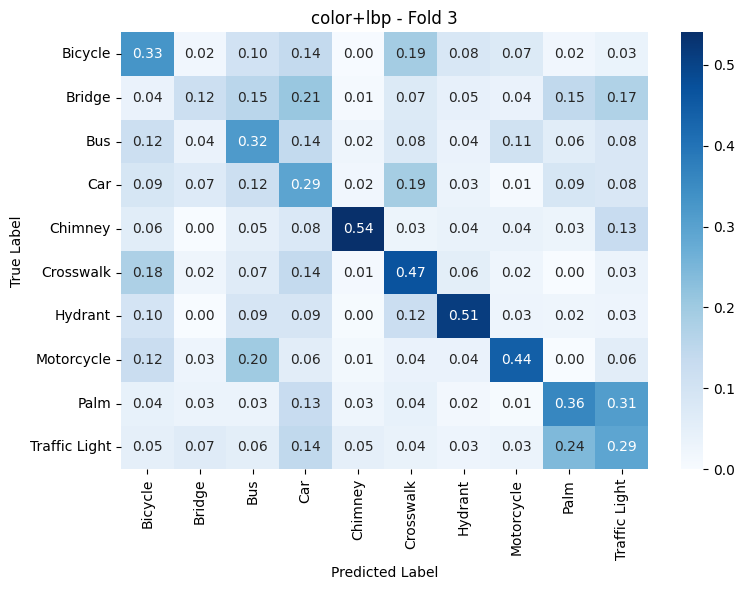


--- 조합: color+lbp+hog (Fold 3) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 3, 조합 color+lbp+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 3, 조합 color+lbp+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4823
    ├ Top-10 Accuracy: 0.8962 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3965 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4802 (Fold 3, 조합 color+lbp+hog)


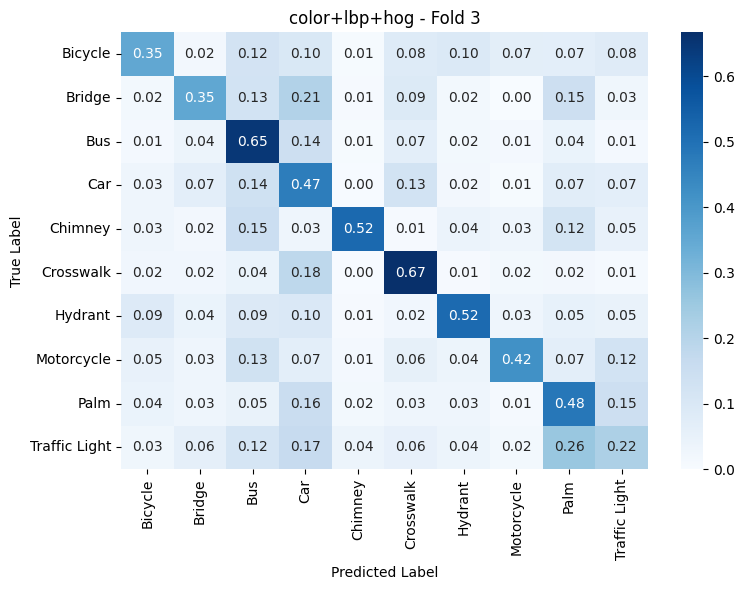


--- 조합: color+law+hog (Fold 3) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 3, 조합 color+law+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 3, 조합 color+law+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4833
    ├ Top-10 Accuracy: 0.8957 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3946 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4808 (Fold 3, 조합 color+law+hog)


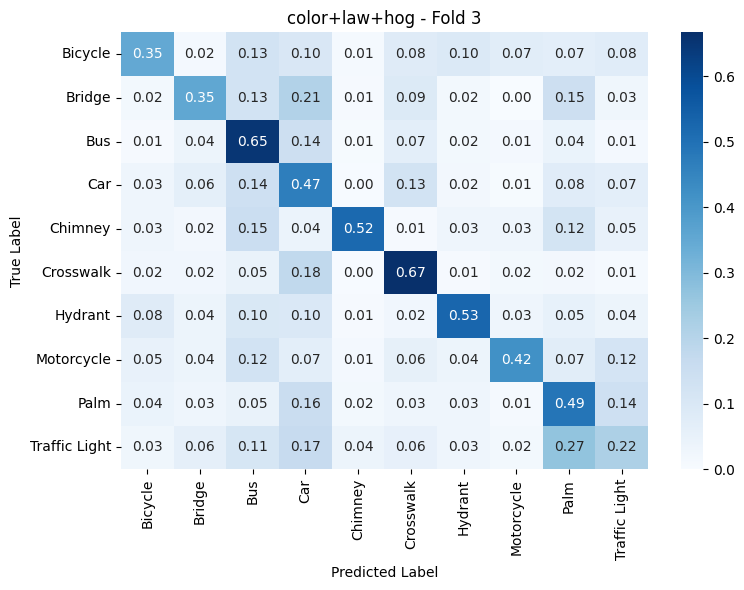


--- 조합: color+lbp+sift+hog (Fold 3) ---
  ✔ BoVW Vocabulary 학습 완료 (200 clusters).
  ⏳ BoVW Histogram 생성 중 (Fold 3, 조합 color+lbp+sift+hog)...
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 3, 조합 color+lbp+sift+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 3, 조합 color+lbp+sift+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4970
    ├ Top-10 Accuracy: 0.9090 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.4118 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4964 (Fold 3, 조합 color+lbp+sift+hog)


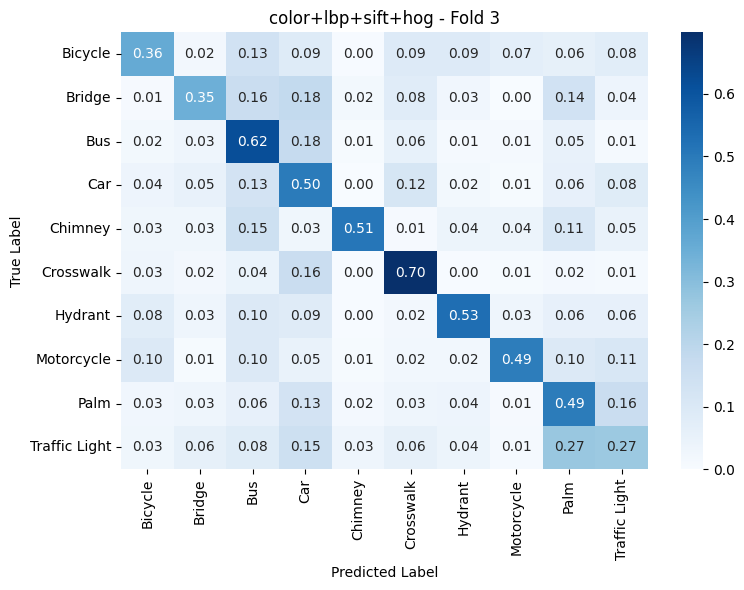


=============== FOLD 4/5 ================
  ⏳ BoVW Vocabulary 학습 중 (Fold 4)

--- 조합: color+lbp (Fold 4) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 4, 조합 color+lbp)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 4, 조합 color+lbp)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.3750
    ├ Top-10 Accuracy: 0.8652 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3193 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.3758 (Fold 4, 조합 color+lbp)


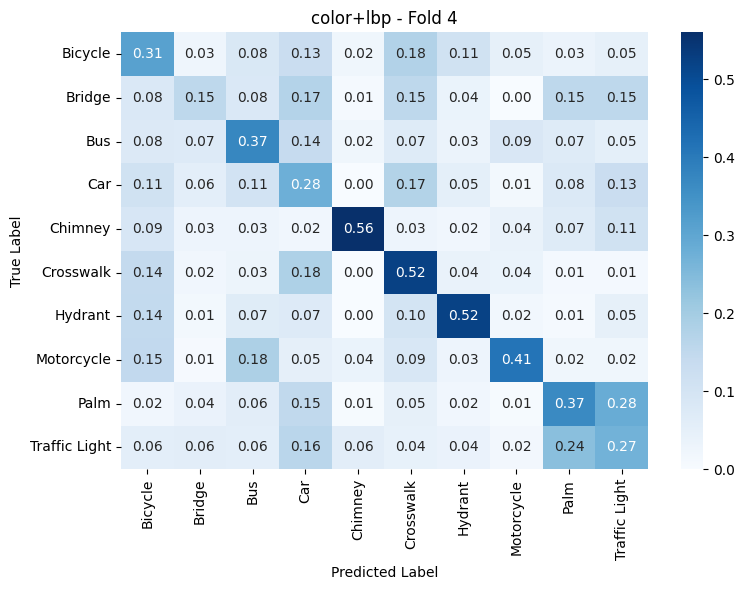


--- 조합: color+lbp+hog (Fold 4) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 4, 조합 color+lbp+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 4, 조합 color+lbp+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4926
    ├ Top-10 Accuracy: 0.8716 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3974 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4912 (Fold 4, 조합 color+lbp+hog)


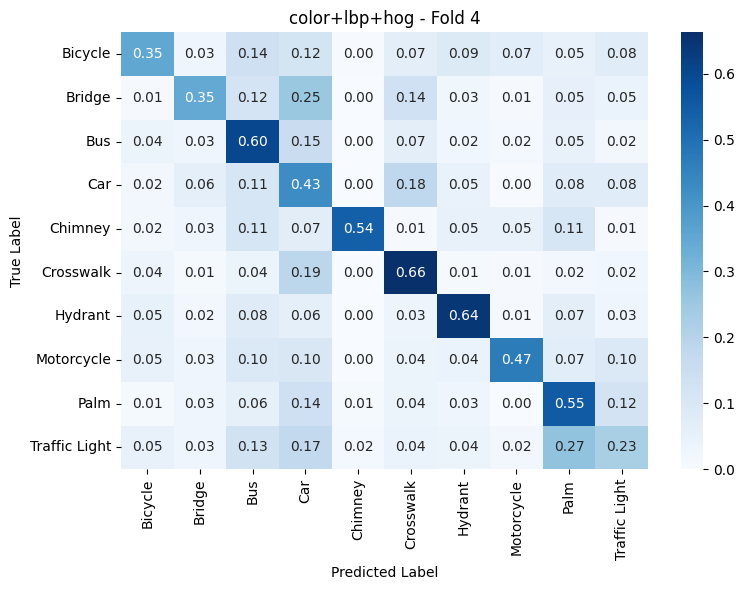


--- 조합: color+law+hog (Fold 4) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 4, 조합 color+law+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 4, 조합 color+law+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4941
    ├ Top-10 Accuracy: 0.8735 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3968 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4922 (Fold 4, 조합 color+law+hog)


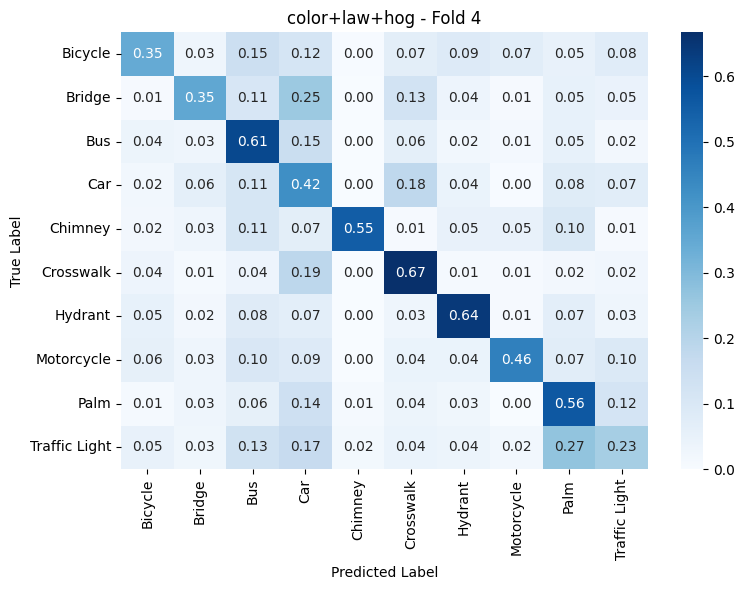


--- 조합: color+lbp+sift+hog (Fold 4) ---
  ✔ BoVW Vocabulary 학습 완료 (200 clusters).
  ⏳ BoVW Histogram 생성 중 (Fold 4, 조합 color+lbp+sift+hog)...
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 4, 조합 color+lbp+sift+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 4, 조합 color+lbp+sift+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.5103
    ├ Top-10 Accuracy: 0.8922 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.4096 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.5099 (Fold 4, 조합 color+lbp+sift+hog)


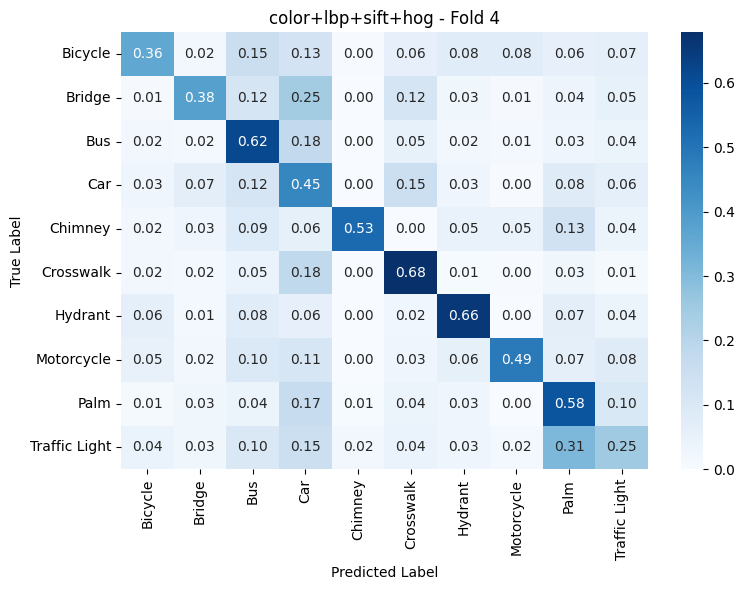


=============== FOLD 5/5 ================
  ⏳ BoVW Vocabulary 학습 중 (Fold 5)

--- 조합: color+lbp (Fold 5) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 5, 조합 color+lbp)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 5, 조합 color+lbp)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.3573
    ├ Top-10 Accuracy: 0.8647 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3186 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.3588 (Fold 5, 조합 color+lbp)


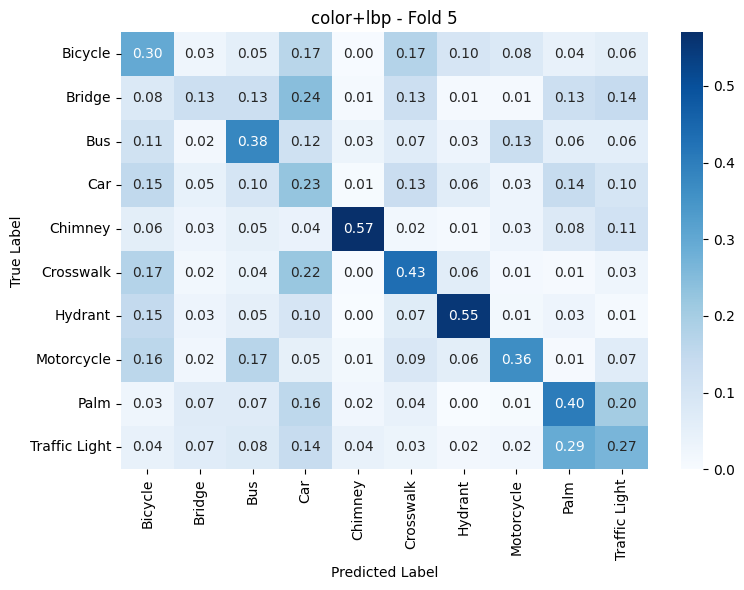


--- 조합: color+lbp+hog (Fold 5) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 5, 조합 color+lbp+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 5, 조합 color+lbp+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4852
    ├ Top-10 Accuracy: 0.8868 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3948 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4794 (Fold 5, 조합 color+lbp+hog)


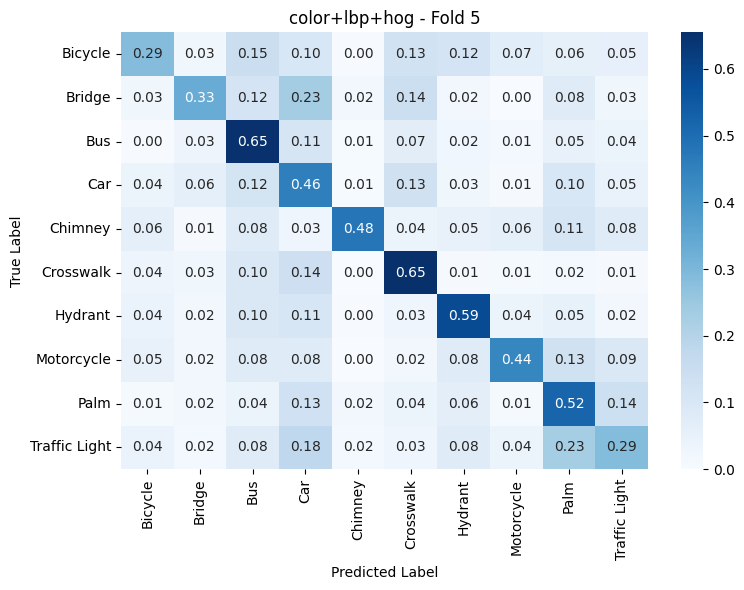


--- 조합: color+law+hog (Fold 5) ---
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 5, 조합 color+law+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 5, 조합 color+law+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.4847
    ├ Top-10 Accuracy: 0.8873 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.3937 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.4787 (Fold 5, 조합 color+law+hog)


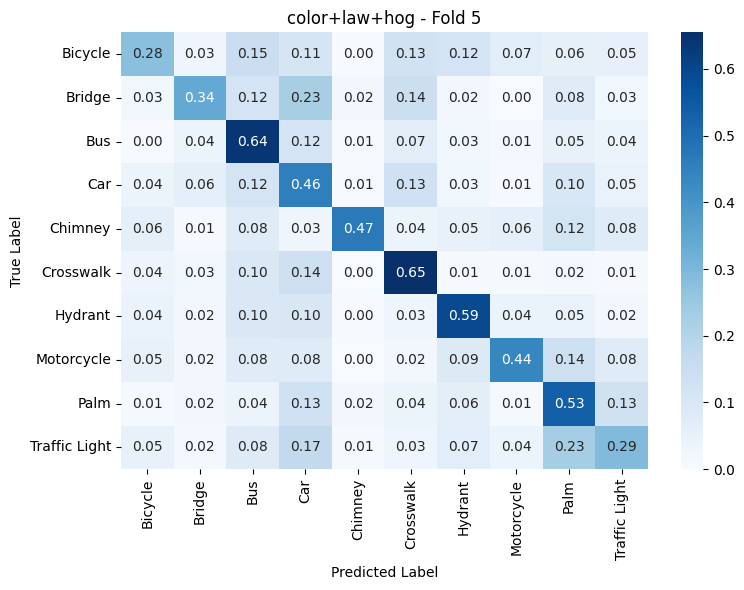


--- 조합: color+lbp+sift+hog (Fold 5) ---
  ✔ BoVW Vocabulary 학습 완료 (200 clusters).
  ⏳ BoVW Histogram 생성 중 (Fold 5, 조합 color+lbp+sift+hog)...
  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold 5, 조합 color+lbp+sift+hog)...
  ▶ KNN 예측 중 (Faiss 사용, k=10, Fold 5, 조합 color+lbp+sift+hog)...
  ✔ 예측 완료.
    ├ Top-1 Accuracy : 0.5069
    ├ Top-10 Accuracy: 0.9001 (정답이 Top-10 안에 있으면 인정)
    └ Task2 Score    : 0.4090 (Top-10 중 정답 등장 비율 평균)
  ✔ F1-Score: 0.5040 (Fold 5, 조합 color+lbp+sift+hog)


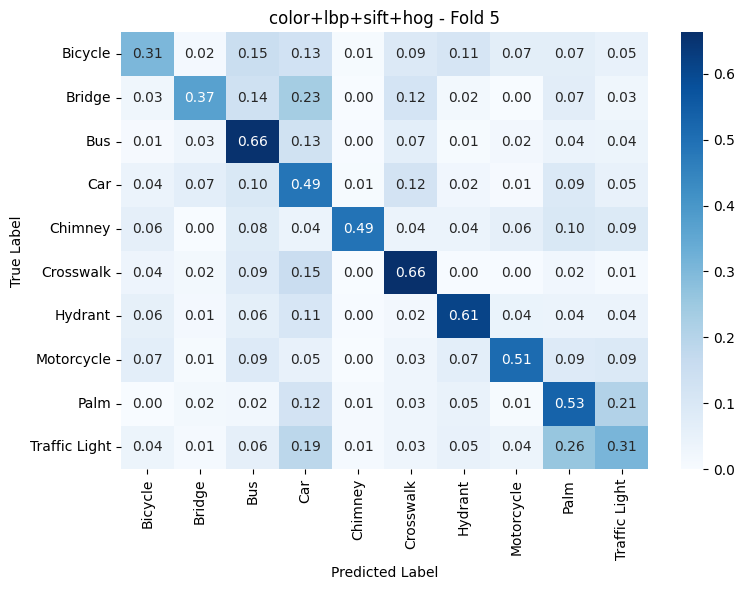



=============== 최종 교차 검증 결과 ================
특징 조합: color+lbp
  Fold 1 Accuracy: 0.3586
  Fold 2 Accuracy: 0.3620
  Fold 3 Accuracy: 0.3642
  Fold 4 Accuracy: 0.3750
  Fold 5 Accuracy: 0.3573
  >> 평균 정확도: 0.3634 (표준편차: 0.0063)
------------------------------
특징 조합: color+lbp+hog
  Fold 1 Accuracy: 0.4806
  Fold 2 Accuracy: 0.4727
  Fold 3 Accuracy: 0.4823
  Fold 4 Accuracy: 0.4926
  Fold 5 Accuracy: 0.4852
  >> 평균 정확도: 0.4827 (표준편차: 0.0065)
------------------------------
특징 조합: color+law+hog
  Fold 1 Accuracy: 0.4791
  Fold 2 Accuracy: 0.4727
  Fold 3 Accuracy: 0.4833
  Fold 4 Accuracy: 0.4941
  Fold 5 Accuracy: 0.4847
  >> 평균 정확도: 0.4828 (표준편차: 0.0070)
------------------------------
특징 조합: color+lbp+sift+hog
  Fold 1 Accuracy: 0.4934
  Fold 2 Accuracy: 0.4860
  Fold 3 Accuracy: 0.4970
  Fold 4 Accuracy: 0.5103
  Fold 5 Accuracy: 0.5069
  >> 평균 정확도: 0.4987 (표준편차: 0.0089)
------------------------------

🏆 최고 성능 조합 (평균 정확도 기준):
  color+lbp+sift+hog: 평균 정확도 = 0.4987


In [38]:
# 사용할 특징 조합 정의
#feature_names = ['color', 'hog', 'lbp', 'sift']
all_feature_combinations_tuples = []
#from itertools import combinations
#for i in range(1, len(feature_names) + 1):
#    for combo in combinations(feature_names, i):
#        all_feature_combinations_tuples.append(combo)

# 사용자가 요청한 특정 조합 추가 (필요시)
user_requested_combinations = [
 ('color', 'lbp'), ('color', 'lbp', 'hog'),
 ('color', 'law', 'hog'),
 ('color', 'lbp', 'sift', 'hog')
]
all_feature_combinations_tuples.extend(user_requested_combinations)
# # 중복 제거
# all_feature_combinations_tuples = sorted(list(set(all_feature_combinations_tuples)))


print(f"\n▶ 총 {len(all_feature_combinations_tuples)}개의 특징 조합에 대해 교차 검증을 수행합니다.")
for combo in all_feature_combinations_tuples:
    print(f"  - {combo}")

# 결과를 저장할 딕셔너리
results = {}
confusion_matrices = {}

X_indices = np.arange(len(images_df)) # StratifiedKFold에 사용할 인덱스
y_labels = images_df['label_encoded'].values

# Stratified K-Fold 준비
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 노트북의 기본 5-fold 사용
print("\n✔ Stratified K-Fold 설정 완료 (5-Fold)")

# 교차 검증 루프
num_bovw_clusters = 200 # BoVW 클러스터 수 (노트북의 get_features_for_split 함수 내 num_bovw_clusters=200 참고, 줄여서 테스트)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_indices, y_labels)):
    print(f"\n=============== FOLD {fold+1}/5 ================")
    y_train_fold, y_val_fold = y_labels[train_idx], y_labels[val_idx]
    # 현재 폴드의 SIFT 디스크립터 (훈련 데이터용, 검증 데이터용)
    sift_descriptors_train_fold = [sift_descriptors_list_all[i] for i in train_idx]
    sift_descriptors_val_fold = [sift_descriptors_list_all[i] for i in val_idx]

    print(f"  ⏳ BoVW Vocabulary 학습 중 (Fold {fold+1})")
    # SIFT 디스크립터가 하나도 없는 경우를 방지
    valid_sift_descriptors_train_fold = [d for d in sift_descriptors_train_fold if d is not None and len(d) > 0]
    bovw_vocabulary = learn_bovw_vocabulary(valid_sift_descriptors_train_fold, num_clusters=num_bovw_clusters)


    # 각 특징 조합에 대해 학습 및 평가
    for feature_combo_tuple in all_feature_combinations_tuples:
        feature_combo_name = '+'.join(feature_combo_tuple)
        print(f"\n--- 조합: {feature_combo_name} (Fold {fold+1}) ---")
        
        X_train_features_list = []
        X_val_features_list = []
        
        if 'color' in feature_combo_tuple:
            X_train_features_list.append(features_color_all[train_idx])
            X_val_features_list.append(features_color_all[val_idx])
        if 'hog' in feature_combo_tuple:
            X_train_features_list.append(features_hog_all[train_idx])
            X_val_features_list.append(features_hog_all[val_idx])
        if 'lbp' in feature_combo_tuple:
            X_train_features_list.append(features_lbp_all[train_idx])
            X_val_features_list.append(features_lbp_all[val_idx])
        if 'laws' in feature_combo_tuple:
            X_train_features_list.append(features_laws_all[train_idx])
            X_val_features_list.append(features_laws_all[val_idx])    
        if 'sift' in feature_combo_tuple:
            if not valid_sift_descriptors_train_fold:
                print(f"  ⚠️ 경고: Fold {fold+1}의 훈련 데이터에 유효한 SIFT 디스크립터가 없어 BoVW 특징을 생성할 수 없습니다. 이 조합/폴드는 건너뜁니다.")
                # 빈 히스토그램 또는 오류 처리
                num_features_sift = num_bovw_clusters 
                train_bovw_hist = np.zeros((len(train_idx), num_features_sift))
                val_bovw_hist = np.zeros((len(val_idx), num_features_sift))
            else:
                if bovw_vocabulary is None or bovw_vocabulary.shape[0] == 0 :
                     print(f"  ⚠️ 경고: Fold {fold+1}에서 BoVW vocabulary 학습에 실패했습니다. 이 조합/폴드는 건너뜁니다.")
                     num_features_sift = num_bovw_clusters 
                     train_bovw_hist = np.zeros((len(train_idx), num_features_sift))
                     val_bovw_hist = np.zeros((len(val_idx), num_features_sift))
                else:
                    print(f"  ✔ BoVW Vocabulary 학습 완료 ({bovw_vocabulary.shape[0]} clusters).")
                    print(f"  ⏳ BoVW Histogram 생성 중 (Fold {fold+1}, 조합 {feature_combo_name})...")
                    # 병렬 처리 + 벡터화된 히스토그램 생성
                    train_bovw_hist = np.array(parallel_create_bovw_histograms(sift_descriptors_train_fold, bovw_vocabulary, n_jobs=-1))
                    val_bovw_hist = np.array(parallel_create_bovw_histograms(sift_descriptors_val_fold, bovw_vocabulary, n_jobs=-1))

            X_train_features_list.append(train_bovw_hist)
            X_val_features_list.append(val_bovw_hist)

        if not X_train_features_list: # 특징이 하나도 선택되지 않은 경우 (일어날 일 없지만 방어 코드)
            print(f"  ⚠️ 경고: 특징이 선택되지 않았습니다 ({feature_combo_name}). 건너뜁니다.")
            continue

        # 특징 결합
        X_train_combined = combine_features(*X_train_features_list)
        X_val_combined = combine_features(*X_val_features_list)
        
        # 데이터 정규화 (필요시 추가 - 예: StandardScaler 또는 MinMaxScaler)
        # scaler = StandardScaler()
        # X_train_combined = scaler.fit_transform(X_train_combined)
        # X_val_combined = scaler.transform(X_val_combined)
        # print("  ℹ️ 특징 정규화 적용됨.")

        print(f"  ⏳ Faiss KNN 모델 학습 중 (k=3, Fold {fold+1}, 조합 {feature_combo_name})...")
        # NaN 또는 Inf 값 확인 및 처리 (중요!)
        if np.isnan(X_train_combined).any() or np.isinf(X_train_combined).any():
            print(f"  ⚠️ 경고: X_train_combined에 NaN 또는 Inf 값이 포함되어 있습니다. 0으로 대체합니다. (조합: {feature_combo_name}, Fold: {fold+1})")
            X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=0.0, neginf=0.0) # 또는 다른 대체 전략
        if np.isnan(X_val_combined).any() or np.isinf(X_val_combined).any():
            print(f"  ⚠️ 경고: X_val_combined에 NaN 또는 Inf 값이 포함되어 있습니다. 0으로 대체합니다. (조합: {feature_combo_name}, Fold: {fold+1})")
            X_val_combined = np.nan_to_num(X_val_combined, nan=0.0, posinf=0.0, neginf=0.0)

        # 특징 벡터가 비어있거나 모든 값이 0인 경우를 처리 (L2 정규화 등에서 문제 발생 가능)
        if X_train_combined.shape[1] == 0:
            print(f"  ⚠️ 경고: 훈련 특징 벡터가 비어있습니다. (조합: {feature_combo_name}, Fold: {fold+1}). 건너뜁니다.")
            continue
        
        # Faiss는 float32 타입을 요구함
        X_train_combined = X_train_combined.astype(np.float32)
        X_val_combined = X_val_combined.astype(np.float32)

        try:
            # train KNN
            faiss_index, train_labels_for_pred, n_neighbors_actual = train_faiss_knn_euclidean(
                X_train_combined, y_train_fold, n_neighbors=10
            )
    
            print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors_actual}, Fold {fold+1}, 조합 {feature_combo_name})...")

            # Top-k label list
            y_pred_topk = predict_faiss_knn_euclidean_topk(
                faiss_index, train_labels_for_pred, n_neighbors_actual, X_val_combined
            )

            # Top-1 predictions (가장 앞에 있는 것만 사용)
            y_pred_fold = [row[0] for row in y_pred_topk]

            # 기존 평가
            acc = accuracy_score(y_val_fold, y_pred_fold)
            fsc = f1_score(y_val_fold, y_pred_fold, average='weighted')

            # ⬇️ Top-10 Accuracy 계산
            top10_hits = [true in top10 for true, top10 in zip(y_val_fold, y_pred_topk)]
            top10_acc = np.mean(top10_hits)

            def task2_score(y_true, topk_preds, topk=10):
                return np.mean([preds.count(t) / topk for t, preds in zip(y_true, topk_preds)])
            task2 = task2_score(y_val_fold, y_pred_topk, topk=10)

            print(f"  ✔ 예측 완료.")
            print(f"    ├ Top-1 Accuracy : {acc:.4f}")
            print(f"    ├ Top-10 Accuracy: {top10_acc:.4f} (정답이 Top-10 안에 있으면 인정)")
            print(f"    └ Task2 Score    : {task2:.4f} (Top-10 중 정답 등장 비율 평균)")
            print(f"  ✔ F1-Score: {fsc:.4f} (Fold {fold+1}, 조합 {feature_combo_name})")

            # Confusion Matrix
            cm = confusion_matrix(y_val_fold, y_pred_fold)
            if feature_combo_name not in confusion_matrices:
                confusion_matrices[feature_combo_name] = {}
            confusion_matrices[feature_combo_name][fold] = cm

            if feature_combo_name not in results:
                results[feature_combo_name] = []
            results[feature_combo_name].append(acc)

            # 시각화
            plot_confusion_matrix(
                cm,
                class_names=['Bicycle','Bridge','Bus', 'Car', 'Chimney','Crosswalk','Hydrant','Motorcycle','Palm','Traffic Light'],
                title=f'{feature_combo_name} - Fold {fold+1}',
                normalize=True
            )
        except Exception as e:
            print(f"  ❌ 오류 발생 (Fold {fold+1}, 조합 {feature_combo_name}): {e}")
            if feature_combo_name not in results:
                results[feature_combo_name] = []
            results[feature_combo_name].append(np.nan)

# 최종 결과 집계 및 출력
print("\n\n=============== 최종 교차 검증 결과 ================")
for combo_name, acc_list in results.items():
    valid_acc_list = [acc for acc in acc_list if not np.isnan(acc)]
    if valid_acc_list:
        mean_acc = np.mean(valid_acc_list)
        std_acc = np.std(valid_acc_list)
        print(f"특징 조합: {combo_name}")
        for i, acc_fold in enumerate(acc_list):
             print(f"  Fold {i+1} Accuracy: {acc_fold:.4f}" if not np.isnan(acc_fold) else f"  Fold {i+1} Accuracy: Error")
        print(f"  >> 평균 정확도: {mean_acc:.4f} (표준편차: {std_acc:.4f})")
    else:
        print(f"특징 조합: {combo_name} - 모든 폴드에서 오류 발생 또는 유효한 결과 없음.")
    print("-" * 30)

# 가장 성능이 좋은 조합 찾기 (평균 정확도 기준)
if results:
    sorted_results = sorted(results.items(), key=lambda item: np.nanmean(item[1]) if item[1] else -1, reverse=True)
    print("\n🏆 최고 성능 조합 (평균 정확도 기준):")
    if sorted_results and np.nanmean(sorted_results[0][1]):
         best_combo_name, best_acc_list = sorted_results[0]
         print(f"  {best_combo_name}: 평균 정확도 = {np.nanmean(best_acc_list):.4f}")
    else:
        print("  유효한 결과를 가진 조합이 없습니다.")